# Фитнес-центр «Культурист-датасаентист»

### План:
1. Загрузка данных и библиотек.
2. Исследовательский анализ данных.
3. Построение модели прогнозирования оттока клиентов.
4. Кластеризация клиентов.
5. Подведение итогов.

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
gym_churn = pd.read_csv('gym_churn.csv')
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
gym_churn.duplicated().sum()

0

***Вывод***

Набор данных включает следующие поля:
* 'Churn' — факт оттока в текущем месяце;
* Текущие поля в датасете:
 * Данные клиента за предыдущий до проверки факта оттока месяц:
  * 'gender' — пол;
  * 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
  * 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
  * Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
  * 'Phone' — наличие контактного телефона;
  * 'Age' — возраст;
  * 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
  * 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
  * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
  * 'Group_visits' — факт посещения групповых занятий;
  * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
  * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
  * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.
  
Дублей и пропусков не обнаружено.

## Исследовательский анализ данных (EDA)

***Посмотрим отсутствующие признаки, средние значения и стандартные отклонения.***

In [6]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


* мужчин и женщин примерно одинаково;
* 85% живут в районе, где находится фитнес центр;
* почти половина является сотрудниками компаний-партнёров;
* около 30% клиентов привели друзья;
* известны номера телефонов 90% клиентов;
* абонемент в среднем на 4.6 месяца;
* 40% групповых занятий;
* средний возраст 29 лет;
* соедняя выручка от дополнительных услуг 146.9;
* в среднем 4.3 месяца до окончания абонемента;
* в среднем 3.7 месяца с момента первого посещения;
* в среднем 1,8 раза в неделю посещения клиента, за предыдущий месяц ;
* 26.5% оттока в текущем месяце.

***Посмотрим на средние значения признаков у тех, кто ушел в отток и тех, кто остался. Построим графики.***

In [7]:
gym_churn.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


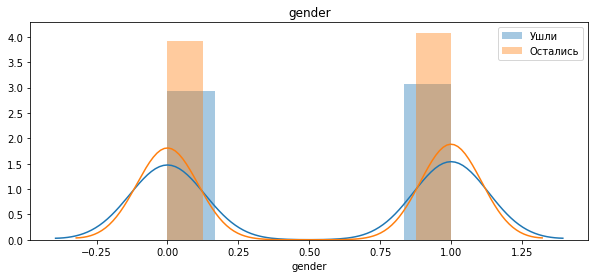

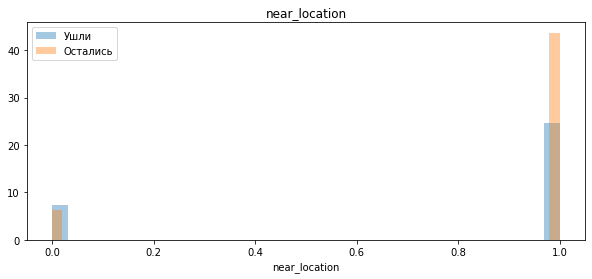

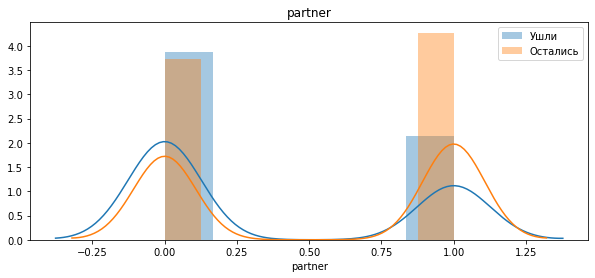

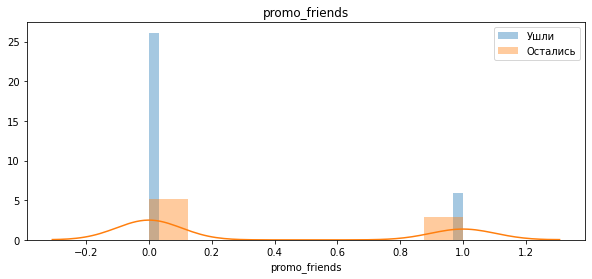

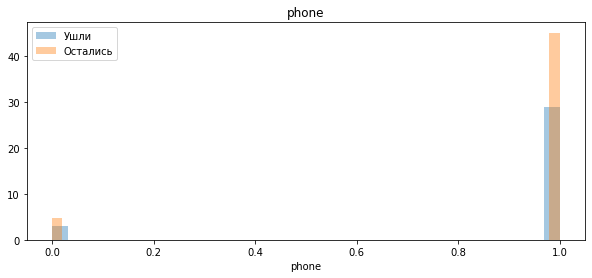

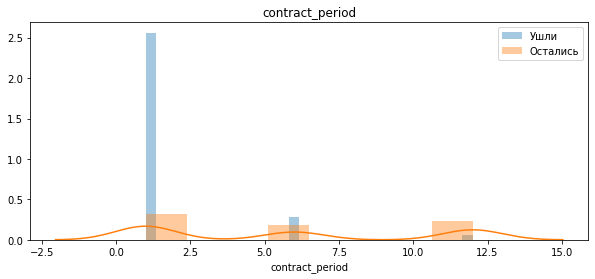

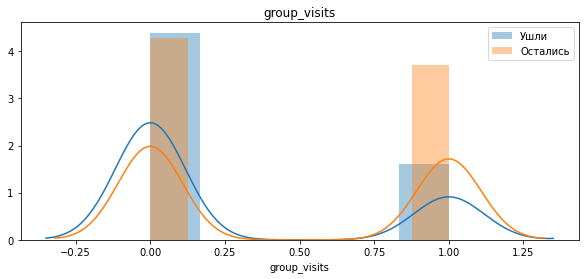

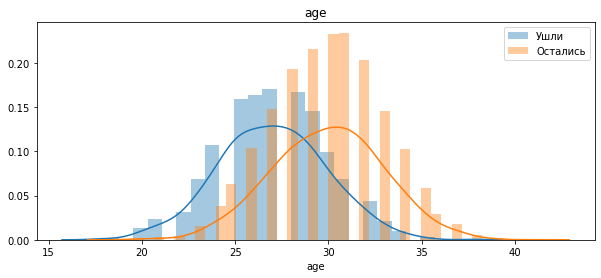

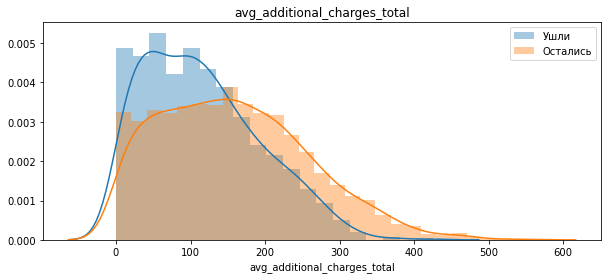

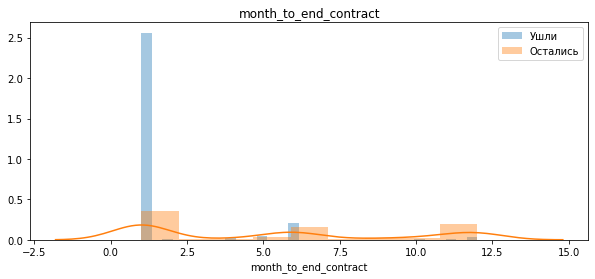

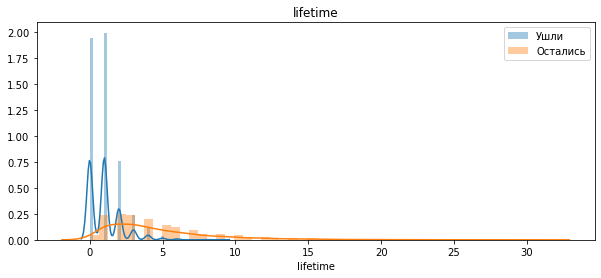

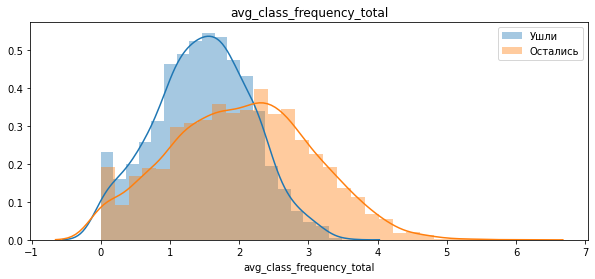

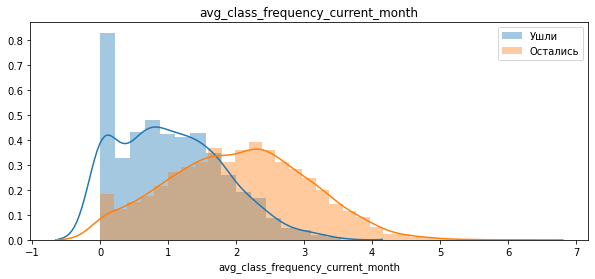

In [8]:
left = gym_churn[gym_churn['churn']==1]
stayed = gym_churn[gym_churn['churn']==0]
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 
           'avg_additional_charges_total', 'month_to_end_contract', 'lifetime','avg_class_frequency_total',
           'avg_class_frequency_current_month']
for column in columns: 
  plt.figure(figsize=(10,4)) 
  plt.title(column)
  sns.distplot(left[column])
  sns.distplot(stayed[column])
  plt.legend(['Ушли', 'Остались'])
  plt.show()

Мужчины и женщины в одинаковой степени остаются и уходят, также нет разницы в наличии номера телефона. В остальных случаях клиенты чаще остаются.

***Построим матрицу корреляций и отобразите её.***

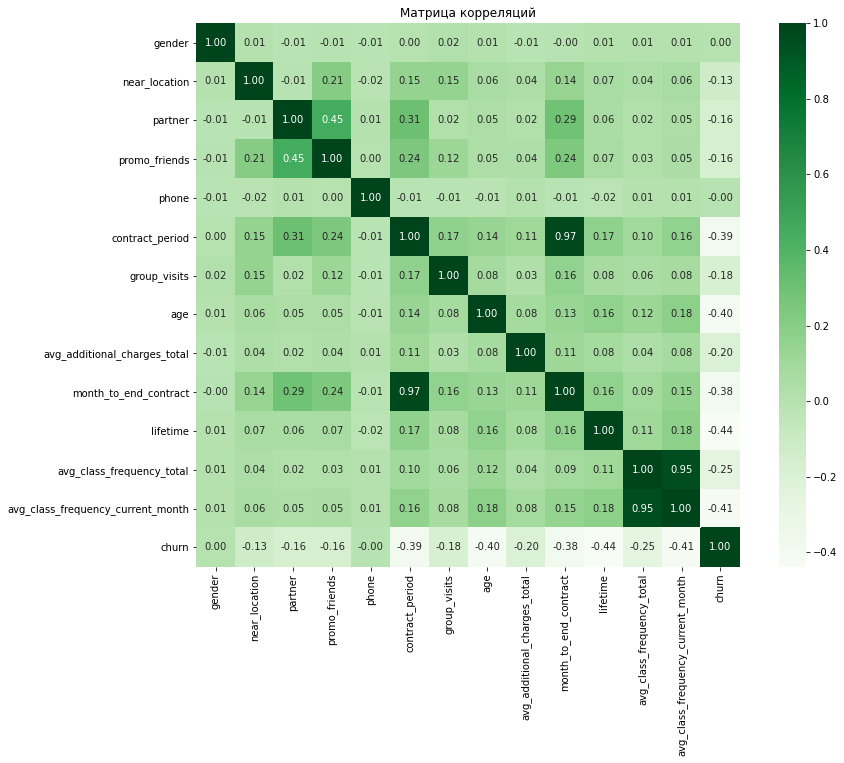

In [9]:
cm = gym_churn.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot = True, square=True, fmt = '0.2f', cmap="Greens")
plt.title('Матрица корреляций')
plt.show()

Есть признаки коррелирующие между собой: длительность абонемента и месяцев до конца абонемента, частота посещений за месяц и за весь период. Признаки phone и gender близки к 0.

## Построение модели прогнозирования оттока клиентов.

*Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.*

***Разобьём данные на обучающую и валидационную выборку.***

In [10]:
X = gym_churn.drop(['churn'], axis = 1)
y = gym_churn['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

***Обучим модель на train-выборке логистической регрессией и случайным лесом.***

In [11]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.91
Precision: 0.83
Recall: 0.81
F1: 0.82


In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


На основании метрик модель регрессии показала себя лучше.

## Кластеризация клиентов.

### Стандартизируем данные и построим дендограмму.

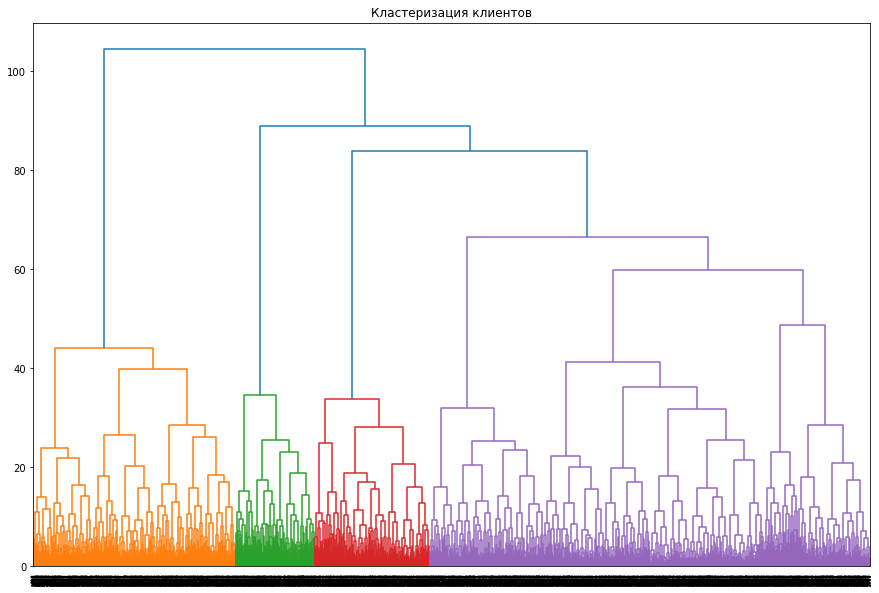

In [13]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

Вычисления предлагают нам выделить 4 кластера, но будем следовать тех. заданию и выберем n=5.

### Обучим модель кластеризации на основании алгоритма K-Means и посмотрим на средние значения признаков для кластеров.

In [14]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_sc)
gym_churn['clusters'] = labels
gym_churn.groupby(['clusters']).mean().sort_values('churn').T

clusters,1,3,2,4,0
gender,0.503490,0.560284,0.522078,0.495050,0.484536
near_location,0.959123,0.976359,0.862338,0.000000,1.000000
partner,0.782652,0.360520,0.470130,0.463366,0.350515
promo_friends,0.573280,0.236407,0.306494,0.079208,0.238699
phone,1.000000,0.998818,0.000000,1.000000,1.000000
contract_period,10.923230,2.689125,4.787013,2.352475,1.953212
group_visits,0.546361,0.470449,0.425974,0.215842,0.340999
age,29.991027,30.114657,29.301299,28.477228,28.165741
avg_additional_charges_total,160.881742,161.376306,143.957664,135.457501,131.686305
month_to_end_contract,9.983051,2.479905,4.475325,2.198020,1.861221


Кластер 4:
* самый большой отток - 56%;
* живут рядом;
* абонементы на короткий срок;
* самые молодые;
* не особо пользуются другими услугами фитнес-центра;
* маленький lifetime;
* редкие посещения.

Кластер 2:
* живут за пределами района, где расположен фитнес-центр;
* их не приводили друзья;
* меньше всех пользуются групповыми занятиями.

Кластер 0:
* достаточно средние показатели, особо ничего не выделить.

Кластер 1:
* самый высокий гендерный признак;
* самые возврастные;
* активно пользуются другим услугми;
* самые высокие показатели посещаемости и lifetime.

Кластер 3:
* самый маленький отток - 2%;
* клиенты из компаний партнёров или пришедшие по совету друзей;
* самый долгосрочный абонемент.

### Построим распределения признаков для кластеров.

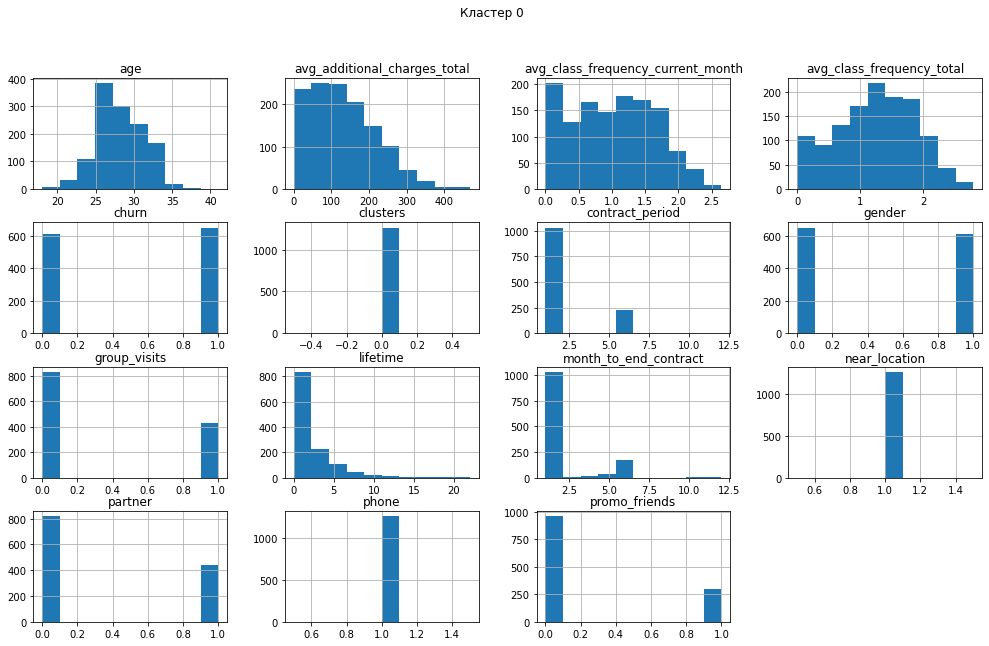

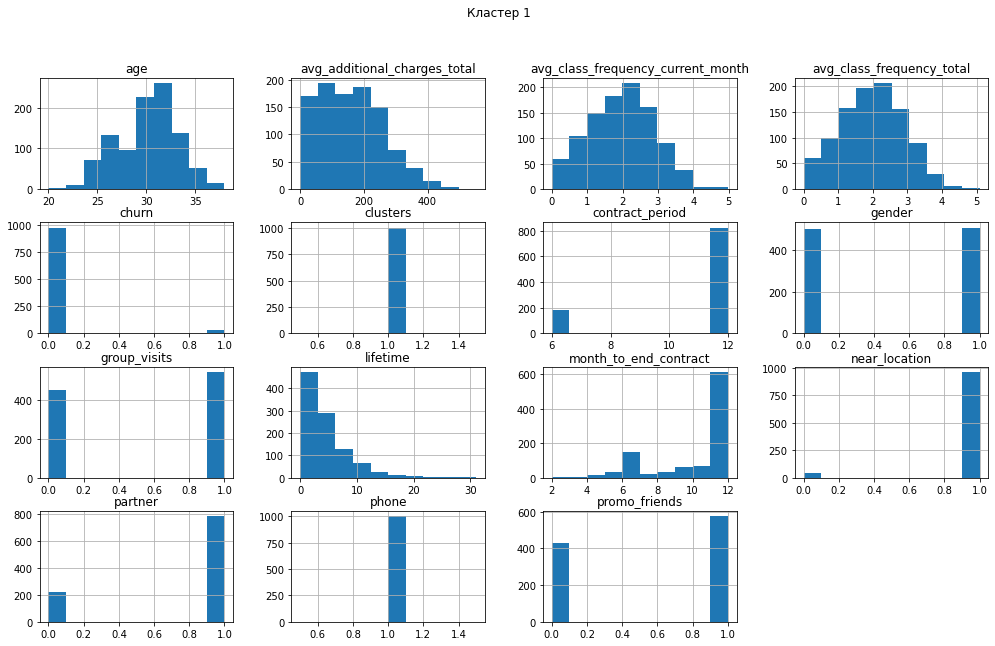

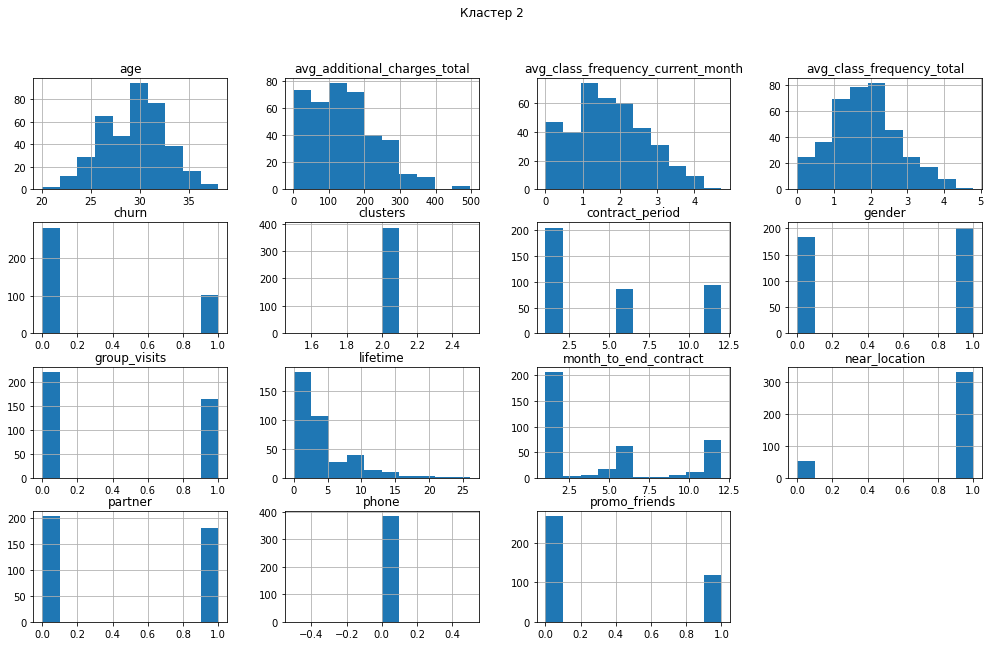

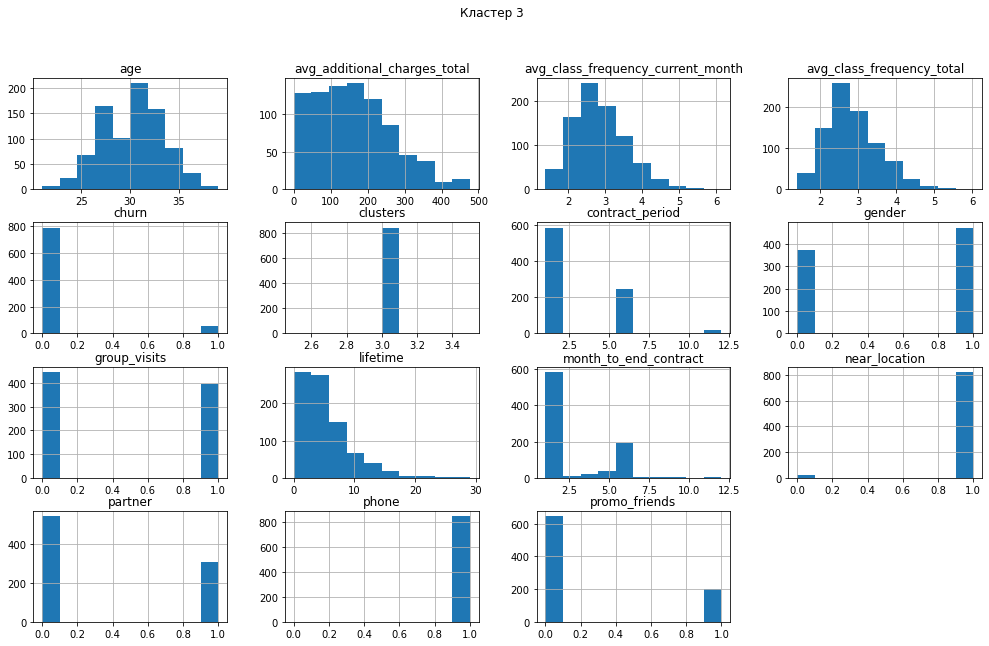

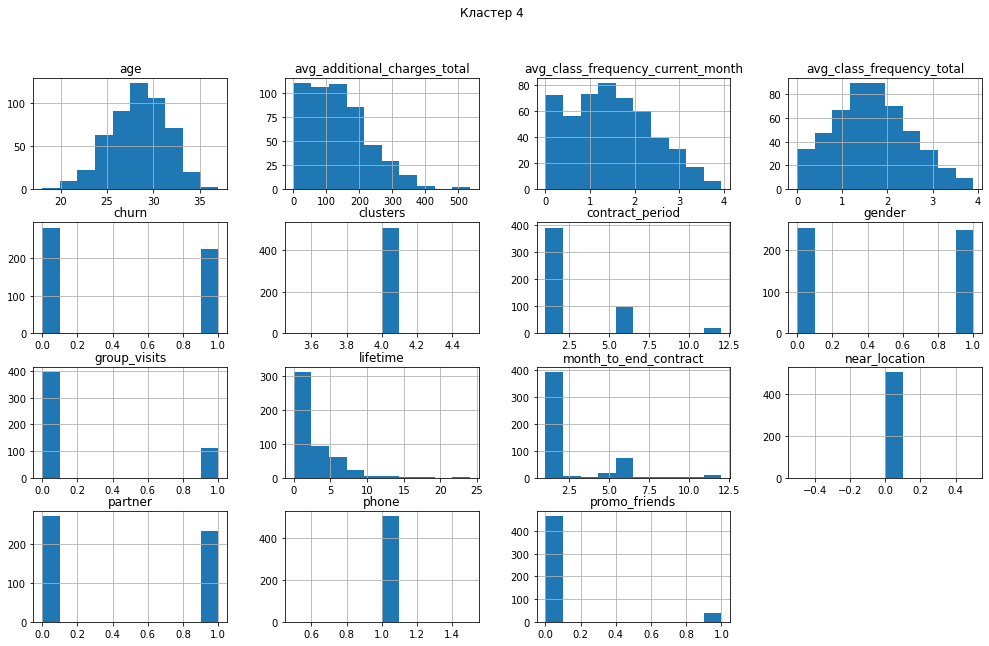

In [15]:
for value in [0, 1, 2, 3, 4]:
  gym_churn[gym_churn['clusters']==value].hist(figsize=(17,10))
  plt.suptitle('Кластер {}'.format(value))
  plt.show()

У кластеров 2 и 4 похожие распределения частоты посещений в текущем месяце. Также похожие распределения долгосрочности абонементов и lifetime. Это кластеры с наибольшим оттоком. Клиенты пришли несколько раз и больше не появлялись.

## Итоги

Явно влияющих признаков на отток нет. Не влияют на уход клиентов гендерные признаки и нанличие контактного телефона. Для кластера с нименьшим оттоком характерны клиенты пришедшие из компаний-партнёров или по рекомендации друзей. Кластер с наибольшим оттоком - скорее всего начинающие, которые забросили это дело либо что-то не понравилось. Соответствено, чем чаще посещение, долгосрочней абонемент, тем меньше отток.

Для уменьшения оттока нужно продолжать расширять сотрудничество с различными компаниями. Также можно разработать систему скидок на длительные абонементы.